In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("sales.csv")
df=df.loc[:,["day","variant_sku"]].dropna()
df.head()
#day column represents the day the item was sold, and variant_sku is the item name.

,day,variant_sku
0,2019-05-01,DFY9_DUV_RUFF_GRY_TXL
1,2019-05-01,DFY9_GCE_3DRWR_WTE
3,2019-05-01,UMBRA_BULLETIN_NKL
5,2019-05-01,THRO9_PLW_RUFFLETIP_GRY
6,2019-05-01,DFY8_COMF_PINKOMBRE_TXL


In [35]:
#creating a subplot for each sku sold over time,lets use the top 10 most sold sku
#Only including those in freq
top10=df.variant_sku.value_counts().index[0:10]
top10df=df[df.variant_sku.isin(top10)]
#Grouping the data
data_group = top10df.groupby(["day", "variant_sku"]).size().to_frame().unstack()
data_group.fillna(0, inplace=True)
data_group.columns = data_group.columns.droplevel(0)

#Reordering groupby output by the most popular items
data_group = data_group[top10.tolist()]
data_group.head()

variant_sku,KA_CLEARLONG_SET,UMBRA_HANGIT_WTE,DD9_BODYPLW_DOWNALT,KA_CLIPLIGHT_SET,THRO7_PLW_MONGOSQ_WTE,DFY9_GCE_3DRWR_WTE,DD9_ENCASEMENT_TXL,DFY8_COMF_EYELSH_WTE_TXL,DFY9_GCE_BEDSIDE_HG,DD9_COMF_HYPO_AS_TXL
day,,,,,,,,,,
2019-05-01,2.0,1.0,0.0,0.0,1.0,6.0,1.0,1.0,3.0,3.0
2019-05-02,2.0,3.0,7.0,3.0,3.0,5.0,1.0,3.0,4.0,6.0
2019-05-03,4.0,2.0,5.0,0.0,4.0,2.0,0.0,5.0,1.0,3.0
2019-05-04,2.0,0.0,3.0,2.0,3.0,2.0,0.0,1.0,1.0,5.0
2019-05-05,2.0,2.0,4.0,6.0,3.0,1.0,0.0,4.0,4.0,1.0


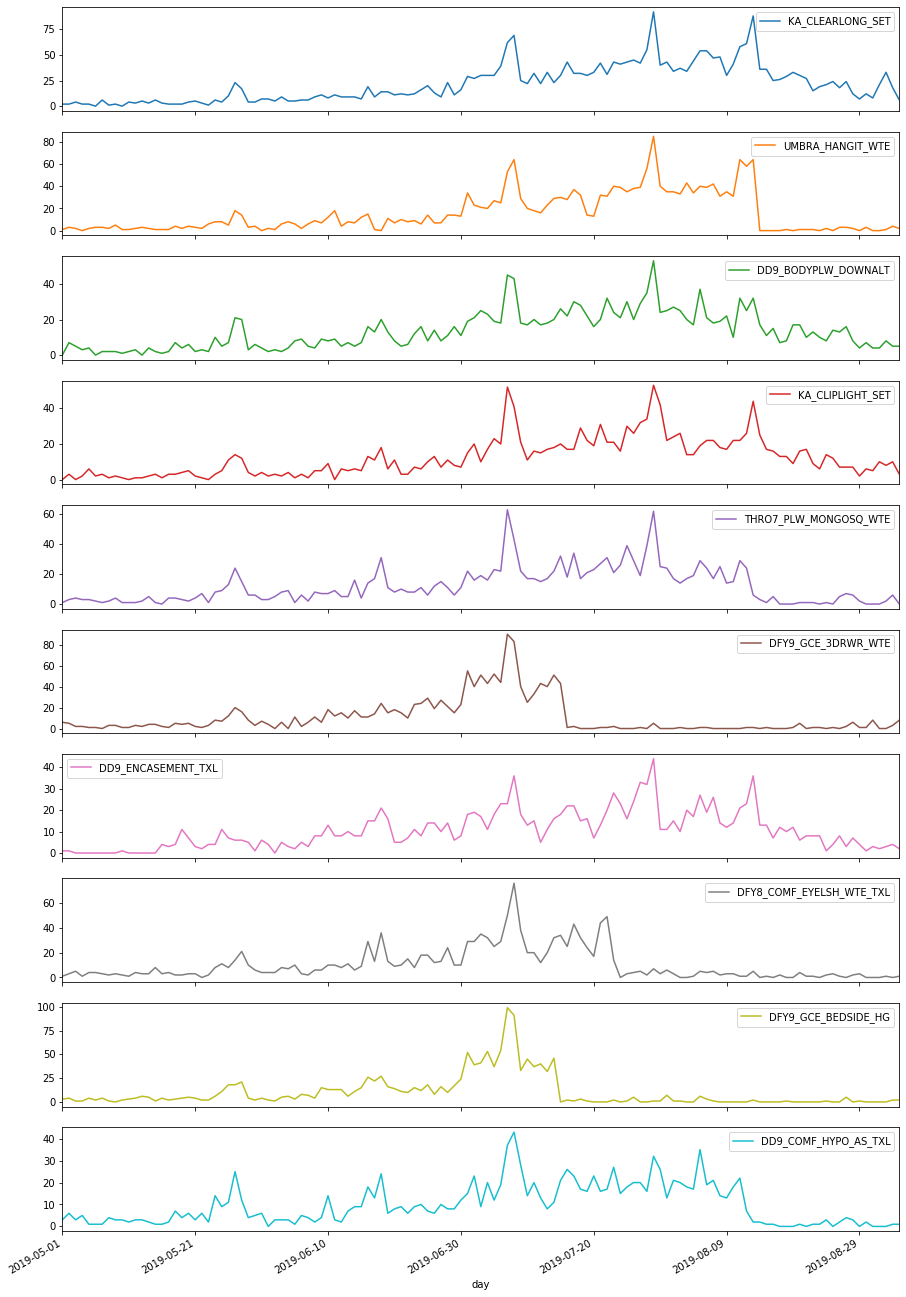

In [37]:
data_group.plot(subplots=True)
plt.rcParams["figure.figsize"]=(15,25)
plt.show()
#we can see some seasonality in our data, as well as clear signs of when an item was sold out.

In [13]:
#function that groups the data by the [sku then day] given range of the data 
def order_number(data, top_x):
    
    #Find the top x variant SKUs
    freq_sku = data['variant_sku'].value_counts().index[0:top_x]
    
    #Finding data only about top x SKUs
    top_sku_data = data[["day", "variant_sku"]]
    top_sku_data.groupby(["variant_sku"]).size()
    top_sku_data = top_sku_data[top_sku_data.variant_sku.isin(freq_sku)]
    
    #DF of how many orders of each item each day

    orders_top_sku = top_sku_data.groupby(["day", "variant_sku"]).size().to_frame().unstack()
    orders_top_sku.fillna(0, inplace=True)
    orders_top_sku.columns = orders_top_sku.columns.droplevel(0)
    
    #Reordering groupby output by the most popular items
    orders_top_sku = orders_top_sku[freq_sku.tolist()]
    
    return orders_top_sku

In [14]:
def get_sellout_dates_comp(df, consecutive_days, greater_than, less_than):
    col = df.columns
    new_df = pd.DataFrame()
    
    item_name=[]
    position_of_item=[]
    day=[]

    
    for i in col:
        item = df[i].to_frame().reset_index()
        lst= item[i].tolist()
        
        
        for j in range(len(lst)):
            if all( num >= greater_than for num in lst[j:j+consecutive_days]) == True:
                if all( num < less_than for num in lst[j+consecutive_days: j+(consecutive_days*2)]) == True:
        
                    item_name.append(i)
                                        
                    #Locate date based on index
                    d = item.iloc[j+consecutive_days-1]
                    day.append(d[0])
                    

        if i not in item_name:
            """pos = 0"""
            item_name.append(i)
            day.append("None")

    
    new_df["Item"] = item_name
    new_df["Sellout Dates"] = day
    
    #Group items with multiple sellout dates
    new_df = new_df.groupby(['Item'], sort=False)["Sellout Dates"].apply(', '.join).reset_index()
   
    return new_df

In [15]:
#by using three consective days of an item selling greater than 10 and three days of an item selling than 10, the results 
#are shown
sm = order_number(df, top_x = 10)
get_sellout_dates_comp(sm, consecutive_days=3, greater_than = 10, less_than = 10)


,Item,Sellout Dates
0,KA_CLEARLONG_SET,"2019-05-28, 2019-09-03"
1,UMBRA_HANGIT_WTE,2019-08-13
2,DD9_BODYPLW_DOWNALT,"2019-06-19, 2019-08-27"
3,KA_CLIPLIGHT_SET,2019-05-28
4,THRO7_PLW_MONGOSQ_WTE,"2019-05-28, 2019-08-12"
5,DFY9_GCE_3DRWR_WTE,"2019-05-28, 2019-07-15"
6,DD9_ENCASEMENT_TXL,"2019-06-19, 2019-08-19"
7,DFY8_COMF_EYELSH_WTE_TXL,"2019-05-29, 2019-07-23"
8,DFY9_GCE_BEDSIDE_HG,"2019-05-28, 2019-07-14"
9,DD9_COMF_HYPO_AS_TXL,"2019-05-28, 2019-06-18, 2019-08-11"
